<center><h1>Enhao_Wang_Final_Project</h1></center>
<br>
<br>

Name: Enhao Wang
<br>
Github Username: EnhaoWang
<br>
USC ID: 8604-0104-78

A sorry to graders: my final project is done on Google Colab, so the indentation and some code is adapted to it.

The project is done on two jupyter nootbook files originally, and I just copied all the cells in the second file here. It looks not as nice as if I wrote all the code in one file, but it will not affect code running.

The data set in 'Data' folder is kept unchanged.

The three .h5 files with 'Image_' are the trained weights of three models in the first image classification task, and the three .h5 files with 'Video_' are the trained weights of three models in the second video classification task.

## 1. Image Classification

The first part is to do the first task, as mentioned from (a) to (e) in the requirement: train on and test on images.

In [1]:
# load data set from Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import os
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

First read the image data.

In [6]:
driver_path='/content/drive/MyDrive/Colab Notebooks/' # Google driver location
num_classes=5
root_path=driver_path+'Data/Sport Images/' # image path
ori_data={}
sports=[]
images=[]
labels=[]
class_num=0

# read all the images and save them and their labels
for folder in os.listdir(root_path):
  if folder!='Image URLs':
    sports.append(folder)
    for file in os.listdir(root_path+folder):
      if not file.startswith(".ipynb_checkpoints") and os.path.splitext(file)[1] not in ['.txt','.gif']: # ignore non-image files
        path=root_path+folder+'/'+file
        img = cv2.imread(path)
        images.append(img)

        label=[0]*num_classes
        label[class_num]=1
        labels.append(label) # each label is five probabilities of classes

    class_num+=1 

Data processing, including splitting into 3 sets, data augmentation, image resize, adjust the data set to the required format.

In [7]:
# This function is to do zero-padding. However, in my work, zero-padding is not used because the desired image size is small.
# def zero_padding(img,target_size):
#   h, w = img.shape[:2]
#   top = (target_size[0] - h) // 2
#   bottom = target_size[0] - h - top
#   left = (target_size[1] - w) // 2
#   right = target_size[1] - w - left

  # Add zero-padding to the image
  # return cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

# split train, validation and test sets
X_train, X_test, y_train, y_test=train_test_split(images,labels,stratify=labels,test_size=0.3)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,stratify=y_test,test_size=0.5)

# data augmentation on training set: randomly perform following methods, each with 0.5 probability
# not using scaling because I shrinked the size of images to (256,256), so it's redundent to zoom or shrink the image again.
# why shrink the image: if the image is too large, the program has a risk of crash on Google Colab. 
train_size=len(X_train)
for i in range(train_size):
  img=X_train[i]
  compose = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=0.5, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0, rotate_limit=0, p=0.5), # translate
    A.RandomCrop(height=min(img.shape[0],img.shape[1]), width=min(img.shape[0],img.shape[1]),p=0.5), 
    # A.RandomScale(scale_limit=(0.25, 0.5),p=0.5), # randomly zoom
  ])
  composed = compose(image=img)
  new_image = composed['image']
  X_train.append(new_image)
  y_train.append(y_train[i])

# resize each image to (256,256,3)
for i in range(len(X_train)):
  X_train[i]=cv2.resize(X_train[i],(256,256))

for i in range(len(X_val)):
  X_val[i]=cv2.resize(X_val[i],(256,256))

for i in range(len(X_test)):
  X_test[i]=cv2.resize(X_test[i],(256,256))

# convert X's and y's to np.array form to feed to models
X_train=np.stack(X_train,axis=0)
X_val=np.stack(X_val,axis=0)
X_test=np.stack(X_test,axis=0)

y_train=np.stack(y_train,axis=0)
y_val=np.stack(y_val,axis=0)
y_test=np.stack(y_test,axis=0)

# convert y's to labels by finding the max probability for each instance
true_label_train=np.argmax(y_train, axis=1)
true_label_test=np.argmax(y_test, axis=1)

Prepare functions for three models.

In [8]:
# train the model
def train_model(base_model,batch_size,root_path):
  for layer in base_model.layers:
    layer.trainable = False # don't train the layers before the last layer
      
  print(f'Model {base_model.name} begins training!')
  # Define the model architecture
  model = Sequential()
  model.add(base_model)
  model.add(Flatten()) # reshape the image
  model.add(Dense(num_classes, activation='relu')) # ReLu activation function
  model.add(Dropout(0.2)) # dropout rate of 20%
  model.add(BatchNormalization()) # batch normalization
  model.add(Dense(num_classes, activation='softmax')) # softmax

  model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy']) # Adam optimizer and multinomial cross entropy loss

  # Define callbacks for early stopping and save the best weights
  early_stopping = EarlyStopping(monitor='val_loss', patience=5)
  model_checkpoint = ModelCheckpoint(filepath=root_path+f"Image_{base_model.name}.h5", monitor='val_loss', save_best_only=True, save_weights_only=True) # save the weights of model

  # train the model with a number of epochs, and perform early stopping
  history = model.fit(X_train, y_train, batch_size=batch_size, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint],workers=16)

  train_val_losses=(history.history['loss'],history.history['val_loss']) # store the train and validation losses on each epoch
  return train_val_losses

# plot train and validation losses in each epoch
def draw_train_val_loss(train_val_losses,name):
  x=[i+1 for i in range(len(train_val_losses[0]))]
  plt.figure(figsize=(10,7))

  plt.plot(x,train_val_losses[0],label='Training Loss')
  plt.plot(x,train_val_losses[1],label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Training and Validation Losses of {name}')
  plt.legend()

  plt.show()

# test the model
def test_model(name,root_path):
  # build the same model as training
  model = Sequential()
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(num_classes, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation='softmax'))

  model.load_weights(root_path+f'Image_{name}.h5') # load the parameters and weights from the training result

  # make predictions on training and test data, and convert probabilities to labels
  y_pred = model.predict(X_train)
  pred_label_train=np.argmax(y_pred, axis=1)

  y_pred = model.predict(X_test)
  pred_label_test=np.argmax(y_pred, axis=1)

  return pred_label_train, pred_label_test

def show_scores(pred_label_train,pred_label_test,name):
  # calculate the confusion matrix
  cm = [confusion_matrix(true_label_train, pred_label_train),confusion_matrix(true_label_test, pred_label_test)]
  # calculate the accuracy
  accuracy = [accuracy_score(true_label_train, pred_label_train),accuracy_score(true_label_test, pred_label_test)]
  # calculate the precision
  precision = [precision_score(true_label_train, pred_label_train, average='weighted'),precision_score(true_label_test, pred_label_test, average='weighted')]
  # calculate the recall
  recall = [recall_score(true_label_train, pred_label_train, average='weighted'),recall_score(true_label_test, pred_label_test, average='weighted')]
  # calculate the F1 score
  f1 = [f1_score(true_label_train, pred_label_train, average='weighted'),f1_score(true_label_test, pred_label_test, average='weighted')]

  # plot the confusion matrix
  fig, axs = plt.subplots(1,2,figsize=(20,7))

  ConfusionMatrixDisplay(confusion_matrix=cm[0],display_labels=sports).plot(ax=axs[0])
  axs[0].set_title(f'Confusion Matrix of {name} on Training Set')

  ConfusionMatrixDisplay(confusion_matrix=cm[1],display_labels=sports).plot(ax=axs[1])
  axs[1].set_title(f'Confusion Matrix of {name} on Test Set')

  plt.show()

  # report the four scores
  print(f'The scores of {name}:\n')
  scores=pd.DataFrame({'Precision':precision,'Recall':recall,'Accuracy':accuracy,'F1 Score':f1},index=['Training set','Test set'])
  print(scores)

Here I did the work for three models seperately.

For each model: 
1. train, 
2. show training and validation losses for each epoch, 
3. test on training and test sets, 
4. show the confusion matrix and scores.

ResNet50

94765736/94765736 [==============================] - 4s 0us/step
Model resnet50 begins training!
Epoch 1/100
18/18 [==============================] - 53s 2s/step - loss: 1.0508 - accuracy: 0.6320 - val_loss: 1.0245 - val_accuracy: 0.5849
Epoch 2/100
18/18 [==============================] - 18s 1s/step - loss: 0.8180 - accuracy: 0.7666 - val_loss: 0.6991 - val_accuracy: 0.7444
Epoch 3/100
18/18 [==============================] - 18s 1s/step - loss: 0.7356 - accuracy: 0.8117 - val_loss: 0.5764 - val_accuracy: 0.8650
Epoch 4/100
18/18 [==============================] - 18s 1s/step - loss: 0.6677 - accuracy: 0.8288 - val_loss: 0.5332 - val_accuracy: 0.8896
Epoch 5/100
18/18 [==============================] - 19s 1s/step - loss: 0.6146 - accuracy: 0.8413 - val_loss: 0.5138 - val_accuracy: 0.8998
Epoch 6/100
18/18 [==============================] - 19s 1s/step - loss: 0.5640 - accuracy: 0.8560 - val_loss: 0.4964 - val_accuracy: 0.9223
Epoch 7/100
18/18 [==============================] - 19s 

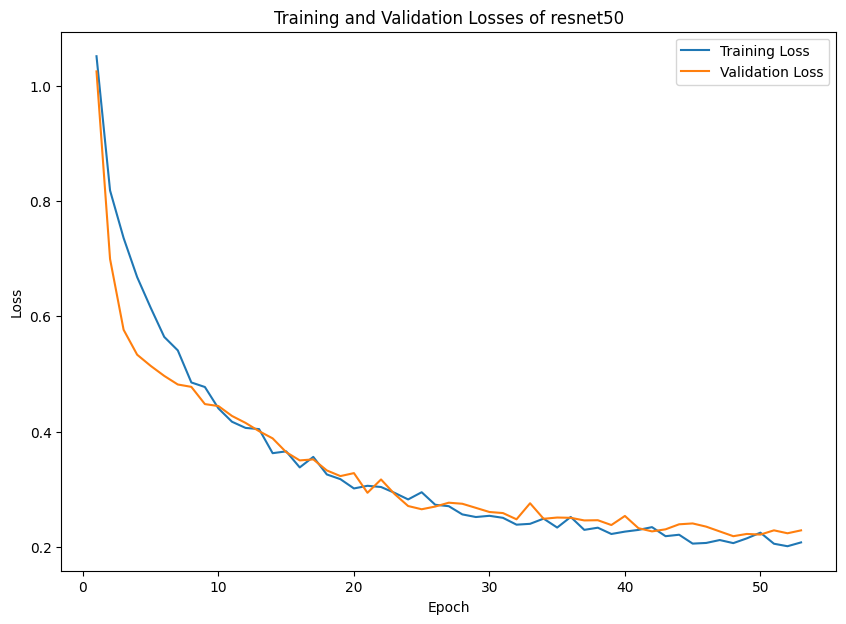

16/16 [==============================] - 2s 151ms/step


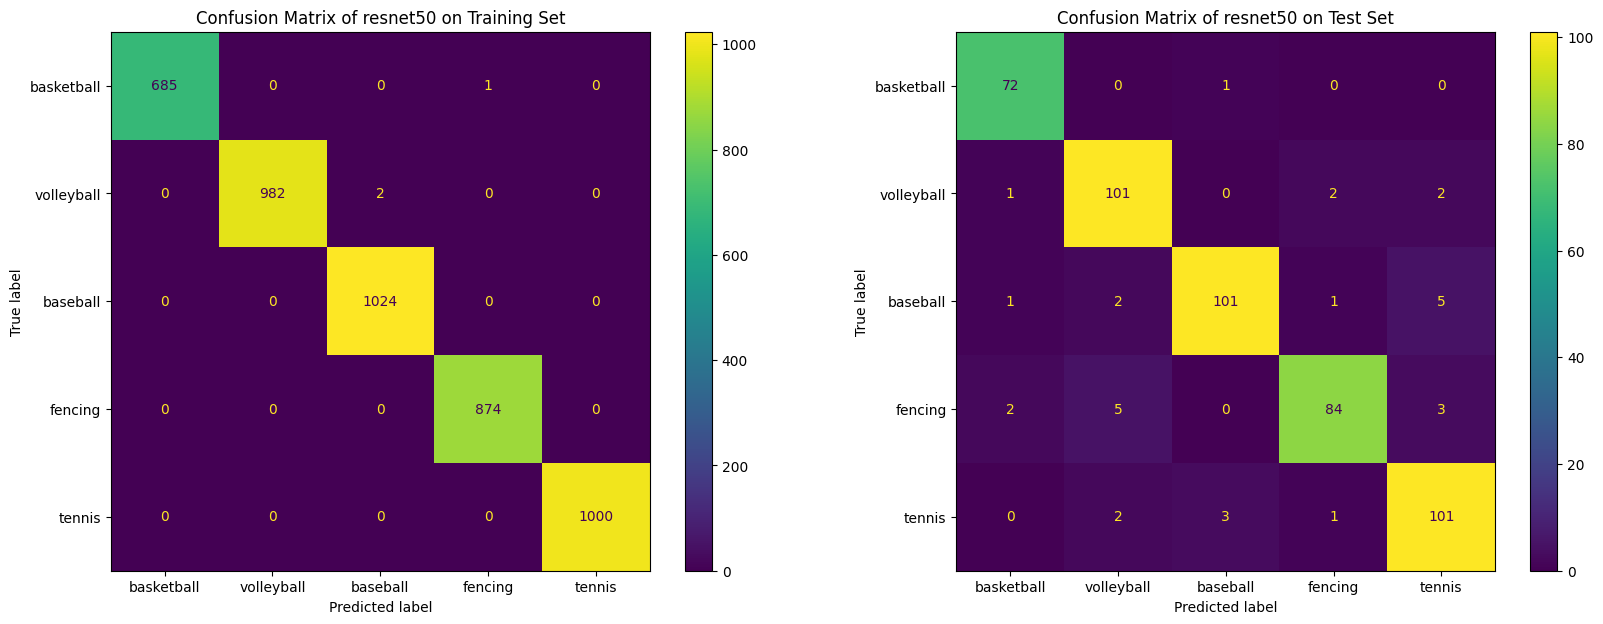

The scores of resnet50:

              Precision    Recall  Accuracy  F1 Score
Training set   0.999344  0.999343  0.999343  0.999343
Test set       0.937515  0.936735  0.936735  0.936622


In [9]:
base_model=ResNet50(weights='imagenet',include_top=False, input_shape=X_train.shape[1:], classes=num_classes) # define ResNet50
# train the model, plot the train and val losses, make predictions on training and test set, and show the score on training and test sets
train_val_losses=train_model(base_model,256,driver_path)
draw_train_val_loss(train_val_losses,base_model.name)
pred_label_train,pred_label_test=test_model(base_model.name,driver_path)
show_scores(pred_label_train,pred_label_test,base_model.name)

From the result, we can see that training is very likely to be overfitted, because the accuracy rate is too high. However, this doesn't affect the performance on test set. The test result is good.

EfficientNetB0

16705208/16705208 [==============================] - 1s 0us/step
Model efficientnetb0 begins training!
Epoch 1/100
18/18 [==============================] - 27s 1s/step - loss: 1.0663 - accuracy: 0.6103 - val_loss: 1.7174 - val_accuracy: 0.5031
Epoch 2/100
18/18 [==============================] - 11s 619ms/step - loss: 0.8084 - accuracy: 0.7544 - val_loss: 0.9197 - val_accuracy: 0.6810
Epoch 3/100
18/18 [==============================] - 12s 665ms/step - loss: 0.7216 - accuracy: 0.7968 - val_loss: 0.7115 - val_accuracy: 0.7505
Epoch 4/100
18/18 [==============================] - 11s 620ms/step - loss: 0.6677 - accuracy: 0.8225 - val_loss: 0.6077 - val_accuracy: 0.8180
Epoch 5/100
18/18 [==============================] - 11s 623ms/step - loss: 0.6022 - accuracy: 0.8535 - val_loss: 0.5618 - val_accuracy: 0.8793
Epoch 6/100
18/18 [==============================] - 11s 627ms/step - loss: 0.5585 - accuracy: 0.8678 - val_loss: 0.5241 - val_accuracy: 0.9182
Epoch 7/100
18/18 [=================

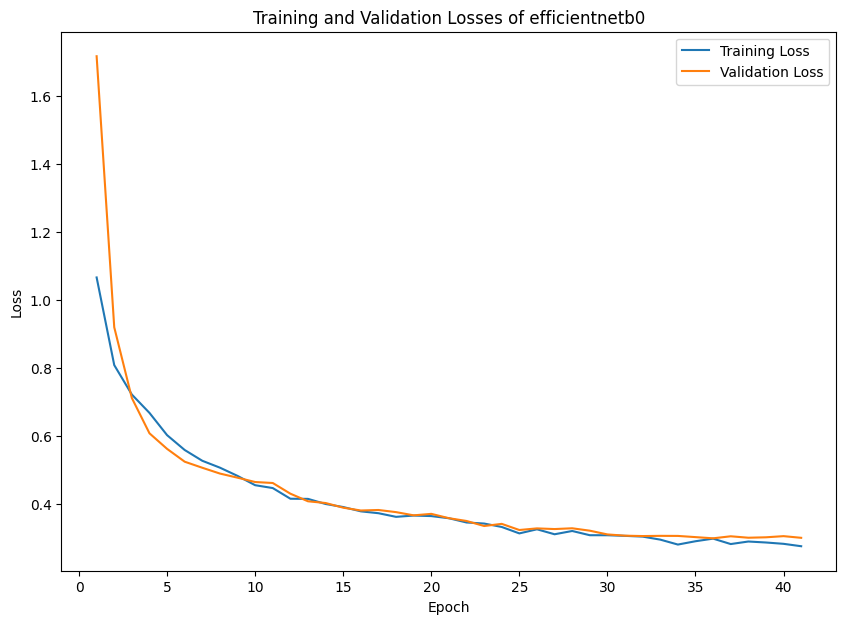

16/16 [==============================] - 2s 104ms/step


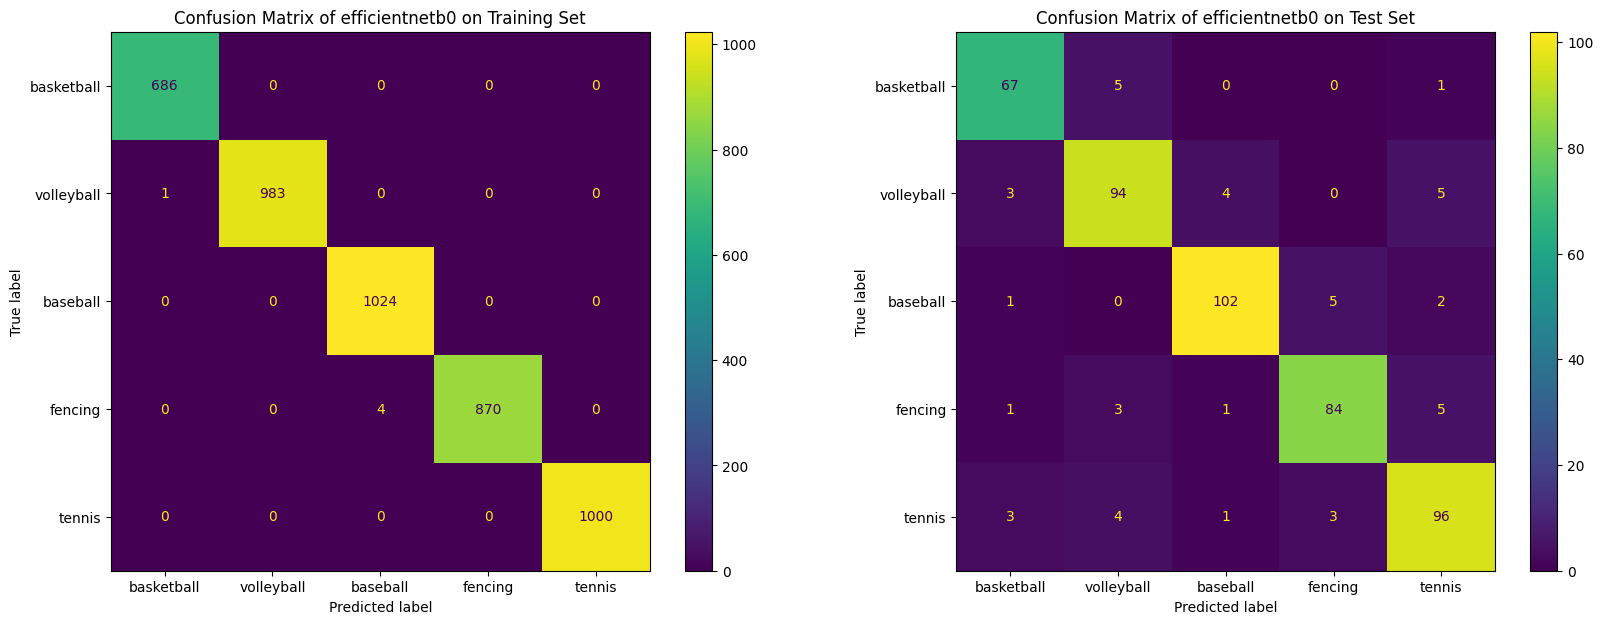

The scores of efficientnetb0:

              Precision    Recall  Accuracy  F1 Score
Training set   0.998909  0.998905  0.998905  0.998905
Test set       0.904422  0.904082  0.904082  0.904173


In [10]:
base_model=EfficientNetB0(weights='imagenet',include_top=False, input_shape=X_train.shape[1:], classes=num_classes) # define EfficientNetB0
# train the model, plot the train and val losses, make predictions on training and test set, and show the score on training and test sets
train_val_losses=train_model(base_model,256,driver_path)
draw_train_val_loss(train_val_losses,base_model.name)
pred_label_train,pred_label_test=test_model(base_model.name,driver_path)
show_scores(pred_label_train,pred_label_test,base_model.name)

The result is very similar to the last model.

VGG16

58889256/58889256 [==============================] - 3s 0us/step
Model vgg16 begins training!
Epoch 1/100
72/72 [==============================] - 51s 568ms/step - loss: 1.0930 - accuracy: 0.5744 - val_loss: 0.6754 - val_accuracy: 0.7485
Epoch 2/100
72/72 [==============================] - 27s 378ms/step - loss: 0.7421 - accuracy: 0.8052 - val_loss: 0.5875 - val_accuracy: 0.8793
Epoch 3/100
72/72 [==============================] - 28s 388ms/step - loss: 0.5860 - accuracy: 0.8656 - val_loss: 0.5571 - val_accuracy: 0.8937
Epoch 4/100
72/72 [==============================] - 28s 393ms/step - loss: 0.4955 - accuracy: 0.8673 - val_loss: 0.4824 - val_accuracy: 0.8896
Epoch 5/100
72/72 [==============================] - 28s 389ms/step - loss: 0.4370 - accuracy: 0.8704 - val_loss: 0.4296 - val_accuracy: 0.8916
Epoch 6/100
72/72 [==============================] - 28s 389ms/step - loss: 0.3815 - accuracy: 0.8838 - val_loss: 0.4216 - val_accuracy: 0.8957
Epoch 7/100
72/72 [=======================

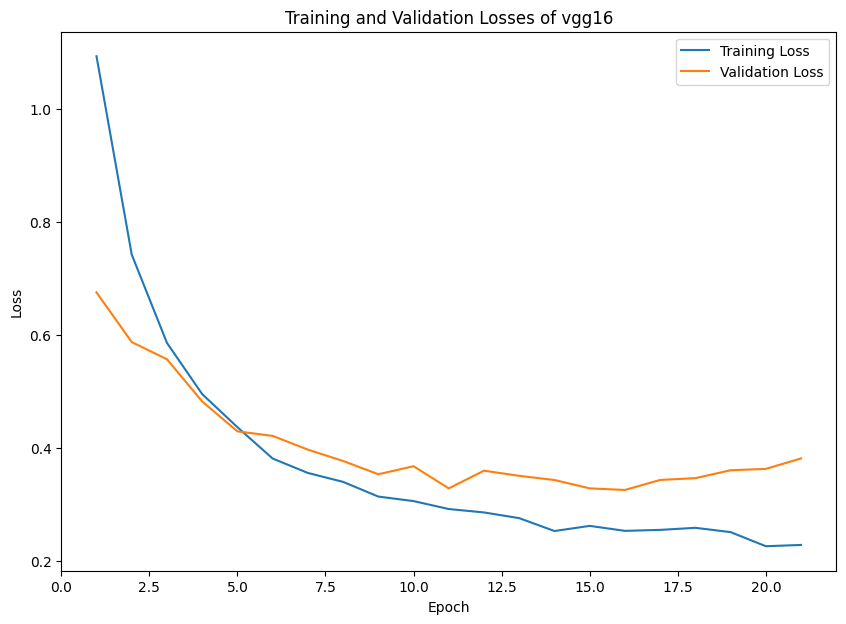

16/16 [==============================] - 5s 308ms/step


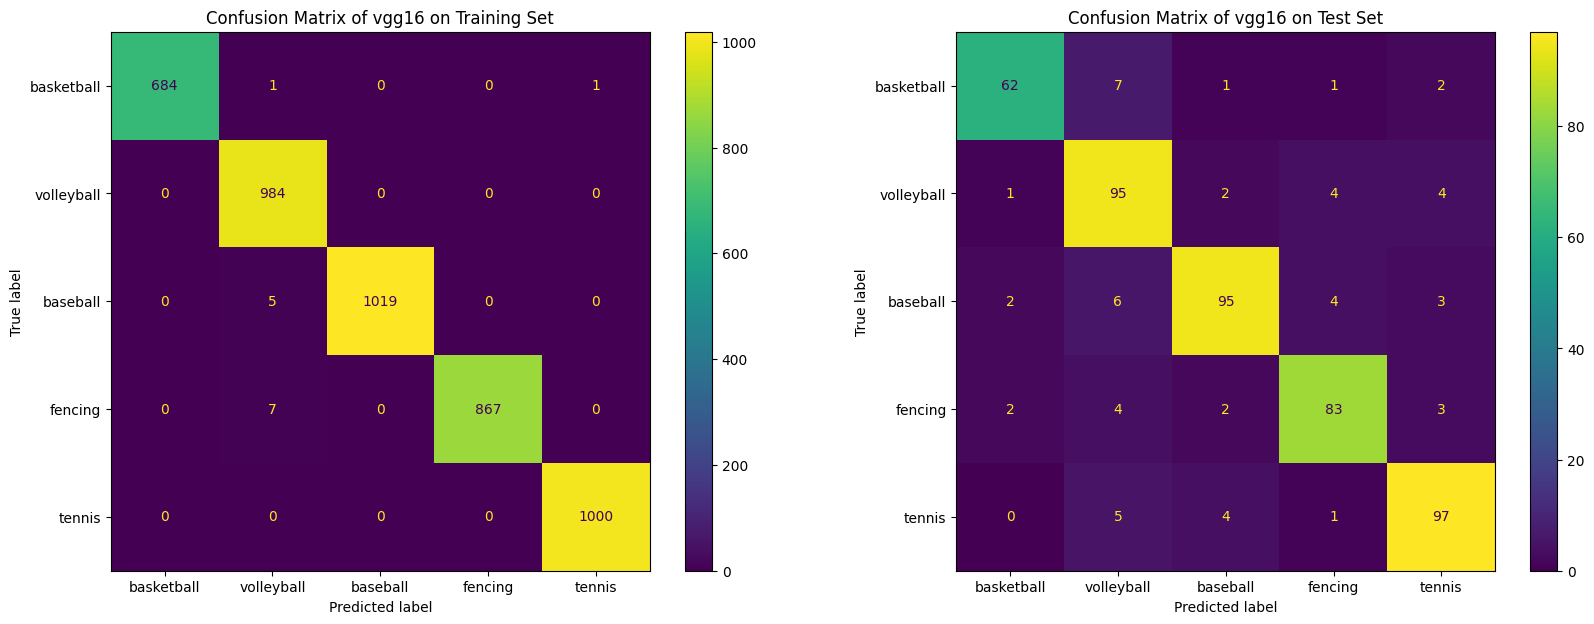

The scores of vgg16:

              Precision    Recall  Accuracy  F1 Score
Training set   0.996973  0.996935  0.996935  0.996940
Test set       0.884110  0.881633  0.881633  0.882001


In [11]:
base_model=VGG16(weights='imagenet',include_top=False, input_shape=X_train.shape[1:], classes=num_classes) # define VGG16
# train the model, plot the train and val losses, make predictions on training and test set, and show the score on training and test sets
train_val_losses=train_model(base_model,64,driver_path)
draw_train_val_loss(train_val_losses,base_model.name)
pred_label_train,pred_label_test=test_model(base_model.name,driver_path)
show_scores(pred_label_train,pred_label_test,base_model.name)

The training and test scores are a little worse than the previous too models. We can also see that early stopping occurs very early. The low number of epochs may indicate it is underfitted comparing to the previous two models.

In conclusion, the three models perform very well on the image classification task.

## 2. Transfer to Video Classification

The second part is to do the second task, as mentioned (f) in the requirement: train on images and test on videos.

In [ ]:
# load data set from Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

First read the image data.

In [ ]:
driver_path='/content/drive/MyDrive/Colab Notebooks/' # Google driver location
num_classes=5
root_path=driver_path+'Data/Sport Images/' # image path
ori_data={}
image_sports=[]
X_train=[]
y_train=[]
class_num=0

# read all the images and save them and their labels
for folder in os.listdir(root_path):
  if folder!='Image URLs':
    image_sports.append(folder)
    for file in os.listdir(root_path+folder):
      if not file.startswith(".ipynb_checkpoints") and os.path.splitext(file)[1] not in ['.txt','.gif']: # ignore non-image files
        path=root_path+folder+'/'+file
        img = cv2.imread(path)
        X_train.append(img)

        label=[0]*num_classes
        label[class_num]=1
        y_train.append(label) # each label is five probabilities of classes

    class_num+=1 

Image data processing, including  data augmentation, image resize, adjust the data set to the required format.

In [ ]:
# data augmentation on training set: randomly perform following methods, each with 0.5 probability
train_size=len(X_train)
for i in range(train_size):
  img=X_train[i]
  compose = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=0.5, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0, rotate_limit=0, p=0.5), # translate
    A.RandomCrop(height=min(img.shape[0],img.shape[1]), width=min(img.shape[0],img.shape[1]),p=0.5), 
    # A.RandomScale(scale_limit=(0.25, 0.5),p=0.5), # randomly zoom
  ])
  composed = compose(image=img)
  new_image = composed['image']
  X_train.append(new_image)
  y_train.append(y_train[i])

# resize each image to (256,256,3)
for i in range(len(X_train)):
  X_train[i]=cv2.resize(X_train[i],(256,256))

# convert X and y to np.array form to feed to models
X_train=np.stack(X_train,axis=0)
y_train=np.stack(y_train,axis=0)

Read video data.

In [ ]:
driver_path='/content/drive/MyDrive/Colab Notebooks/'
root_path=driver_path+'Data/Sport Videos/'
videos=[]
labels=[]
class_num=0

mappingtable={'baseball':'BaseballPitch','basketball':'Basketball','fencing':'Fencing','tennis':'TennisSwing','volleyball':'VolleyballSpiking'}
video_sports=[mappingtable[sport] for sport in image_sports]

for folder in video_sports:
  for file in os.listdir(root_path+folder): 
    if not file.startswith(".ipynb_checkpoints"):# and os.path.splitext(file)[1] not in ['.avi']:
      video_frames=[]
      path=root_path+folder+'/'+file
      
      video = cv2.VideoCapture(path) # Open the video file
      
      total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))# Get the total number of frames in the video

      frame_interval = (total_frames-1) / 99 # Calculate the interval between frames

      current_frame = 0

      for i in range(100):
        
        video.set(cv2.CAP_PROP_POS_FRAMES, current_frame) # Set the video's current frame to the desired frame
        
        # Read the frame
        ret, frame = video.read()
        
        if frame is None: # in case the frame is beyond the video
          break

        frame=cv2.resize(frame,(256,256)) # resize the frame(image) to (256,256,3)

        video_frames.append(frame)
        current_frame += frame_interval

      video.release()

      video_frames=np.stack(video_frames,axis=0)
      videos.append(video_frames)

      label=[0]*num_classes
      label[class_num]=1
      labels.append(label) # each label is five probabilities of classes 
  class_num+=1

true_label_test=np.argmax(labels, axis=1) # convert y to labels by finding the max probability for each instance                 

Prepare functions for three models.

In [ ]:
# train the model
def train_model(base_model,batch_size,epochs,root_path):
  for layer in base_model.layers:
    layer.trainable = False # don't train the layers before the last layer
      
  print(f'Model {base_model.name} begins training!')
  # Define the model architecture
  model = Sequential()
  model.add(base_model)
  model.add(Flatten()) # reshape the image
  model.add(Dense(num_classes, activation='relu')) # ReLu activation function
  model.add(Dropout(0.2)) # dropout rate of 20%
  model.add(BatchNormalization()) # batch normalization
  model.add(Dense(num_classes, activation='softmax')) # softmax

  model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy']) # Adam optimizer and multinomial cross entropy loss

  # Define callbacks for early stopping and saving the best weights
  early_stopping = EarlyStopping(monitor='loss', patience=1000)
  model_checkpoint = ModelCheckpoint(filepath=root_path+f"Video_{base_model.name}.h5", monitor='loss', save_best_only=True, save_weights_only=True) # save the weights of model

  # train the model with a number of epochs
  history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping, model_checkpoint],workers=16)

# test the model
def test_model(name,root_path,videos):
  # build the same model as training
  model = Sequential()
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(num_classes, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation='softmax'))

  model.load_weights(root_path+f'Image_{name}.h5') # load the parameters and weights from the training result
  
  # for each video, make predictions on video frames, take average of probabilities, and convert probabilities to labels 
  pred_label_test=[]
  for X_test in videos:
    y_pred = model.predict(X_test)
    class_prob=np.average(y_pred, axis=0)
    pred_label_test.append(np.argmax(class_prob))

  return np.array(pred_label_test)

def show_scores(true_label_test,pred_label_test,name,sports):
  # calculate the confusion matrix
  cm = confusion_matrix(true_label_test, pred_label_test)
  # calculate the accuracy
  accuracy = accuracy_score(true_label_test, pred_label_test)
  # calculate the precision
  precision = precision_score(true_label_test, pred_label_test, average='weighted')
  # calculate the recall
  recall = recall_score(true_label_test, pred_label_test, average='weighted')
  # calculate the F1 score
  f1 = f1_score(true_label_test, pred_label_test, average='weighted')

  # plot the confusion matrix
  fig, ax = plt.subplots(figsize=(20,7))

  ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sports).plot(ax=ax)
  ax.set_title(f'Confusion Matrix of {name} on Video Data Set')

  plt.show()

  # report the four scores
  print(f'The scores of {name}:\n')
  scores=pd.DataFrame({'Precision':precision,'Recall':recall,'Accuracy':accuracy,'F1 Score':f1},index=['Video Data'])
  print(scores)

Similarly, I did the work for three models seperately.

For each model: 
1. train on the entire augmented image data, with the nubmer of epochs same as previous ones using validation set, and don't use validation set here, 
2. test on video data, 
3. show the confusion matrix and scores.

ResNet50

94765736/94765736 [==============================] - 3s 0us/step
Model resnet50 begins training!
Epoch 1/53
26/26 [==============================] - 47s 1s/step - loss: 1.0087 - accuracy: 0.6609
Epoch 2/53
26/26 [==============================] - 23s 883ms/step - loss: 0.7750 - accuracy: 0.7905
Epoch 3/53
26/26 [==============================] - 23s 891ms/step - loss: 0.6859 - accuracy: 0.8238
Epoch 4/53
26/26 [==============================] - 23s 899ms/step - loss: 0.6022 - accuracy: 0.8518
Epoch 5/53
26/26 [==============================] - 24s 911ms/step - loss: 0.5471 - accuracy: 0.8573
Epoch 6/53
26/26 [==============================] - 23s 900ms/step - loss: 0.4996 - accuracy: 0.8739
Epoch 7/53
26/26 [==============================] - 23s 900ms/step - loss: 0.4412 - accuracy: 0.8930
Epoch 8/53
26/26 [==============================] - 23s 902ms/step - loss: 0.4073 - accuracy: 0.9024
Epoch 9/53
26/26 [==============================] - 23s 902ms/step - loss: 0.3946 - accuracy: 0.89

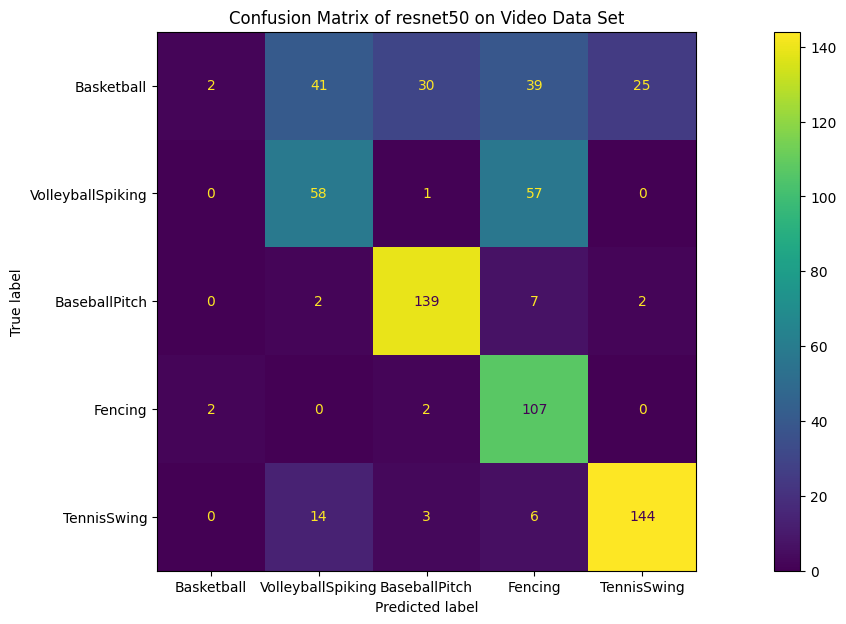

The scores of resnet50:

            Precision    Recall  Accuracy  F1 Score
Video Data     0.6487  0.660793  0.660793  0.595277


In [ ]:
base_model=ResNet50(weights='imagenet',include_top=False, input_shape=X_train.shape[1:], classes=num_classes) # define ResNet50
# train the model, make predictions on video data, and show the score
train_model(base_model,256,53,driver_path)
pred_label_test=test_model(base_model.name,driver_path,videos)
show_scores(true_label_test,pred_label_test,base_model.name,video_sports)

The scores are not very good.

EfficientNetB0

16705208/16705208 [==============================] - 1s 0us/step
Model efficientnetb0 begins training!
Epoch 1/41
26/26 [==============================] - 22s 560ms/step - loss: 1.0932 - accuracy: 0.6063
Epoch 2/41
26/26 [==============================] - 15s 574ms/step - loss: 0.8676 - accuracy: 0.6892
Epoch 3/41
26/26 [==============================] - 15s 578ms/step - loss: 0.7652 - accuracy: 0.7441
Epoch 4/41
26/26 [==============================] - 15s 578ms/step - loss: 0.6725 - accuracy: 0.7988
Epoch 5/41
26/26 [==============================] - 15s 580ms/step - loss: 0.6198 - accuracy: 0.8215
Epoch 6/41
26/26 [==============================] - 16s 601ms/step - loss: 0.5590 - accuracy: 0.8572
Epoch 7/41
26/26 [==============================] - 15s 578ms/step - loss: 0.5170 - accuracy: 0.8702
Epoch 8/41
26/26 [==============================] - 15s 583ms/step - loss: 0.4824 - accuracy: 0.8791
Epoch 9/41
26/26 [==============================] - 15s 578ms/step - loss: 0.4389 - accur

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


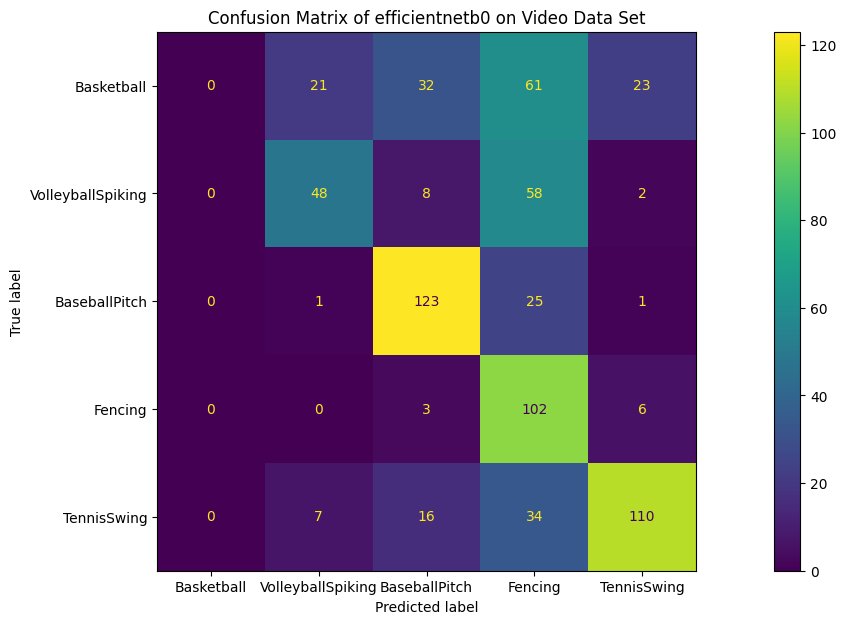

The scores of efficientnetb0:

            Precision    Recall  Accuracy  F1 Score
Video Data   0.504387  0.562408  0.562408  0.507572


In [ ]:
base_model=EfficientNetB0(weights='imagenet',include_top=False, input_shape=X_train.shape[1:], classes=num_classes) # define EfficientNetB0
# train the model, make predictions on video data, and show the score
train_model(base_model,256,41,driver_path)
pred_label_test=test_model(base_model.name,driver_path,videos)
show_scores(true_label_test,pred_label_test,base_model.name,video_sports)

Poorer scores.

VGG16

58889256/58889256 [==============================] - 2s 0us/step
Model vgg16 begins training!
Epoch 1/21
102/102 [==============================] - 53s 412ms/step - loss: 1.0733 - accuracy: 0.6178
Epoch 2/21
102/102 [==============================] - 33s 320ms/step - loss: 0.7194 - accuracy: 0.7905
Epoch 3/21
102/102 [==============================] - 33s 325ms/step - loss: 0.5528 - accuracy: 0.8508
Epoch 4/21
102/102 [==============================] - 33s 326ms/step - loss: 0.4444 - accuracy: 0.8725
Epoch 5/21
102/102 [==============================] - 33s 324ms/step - loss: 0.3800 - accuracy: 0.8917
Epoch 6/21
102/102 [==============================] - 33s 324ms/step - loss: 0.3354 - accuracy: 0.9050
Epoch 7/21
102/102 [==============================] - 33s 326ms/step - loss: 0.3084 - accuracy: 0.9125
Epoch 8/21
102/102 [==============================] - 34s 330ms/step - loss: 0.2839 - accuracy: 0.9134
Epoch 9/21
102/102 [==============================] - 32s 317ms/step - loss: 0.285

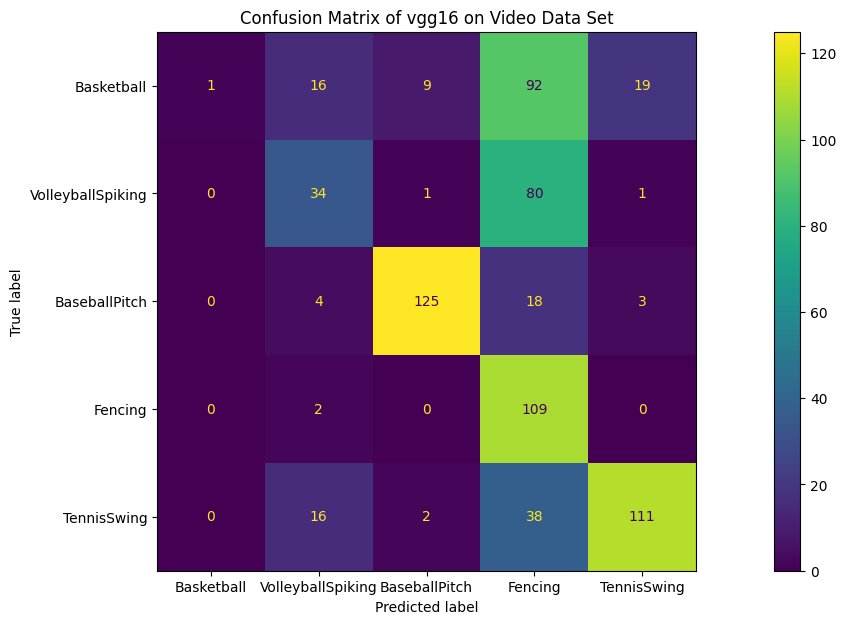

The scores of vgg16:

            Precision    Recall  Accuracy  F1 Score
Video Data   0.738439  0.558003  0.558003  0.516575


In [ ]:
base_model=VGG16(weights='imagenet',include_top=False, input_shape=X_train.shape[1:], classes=num_classes) # define VGG16
# train the model, make predictions on video data, and show the score
train_model(base_model,64,21,driver_path)
pred_label_test=test_model(base_model.name,driver_path,videos)
show_scores(true_label_test,pred_label_test,base_model.name,video_sports)

Also not very good.

There is something strange that the three models barely classify to basketball. This phenomenon is not by accident on one model, because it happens on all three models. Probably this problem is from the data set. I checked the images and videos for basketball, and my guess is that the environments of images and videos for basketball is different. The images are mainly from games(like NBA), but videos are just amateur playing. The basketball court are also very different.

In conclusion, the performance of three models are similar. They have similar scores and similar situation, like barely classifying to basketball and lots of other sports are classified as fencing. Although these are three different models, they are yielding similar results. I think this may because the characteristic of the data set makes it hard for image classification models, or because we only trained the last classification layer.

I believe I can have a better performance on this data set if I make some modifications on the model, which can be my future work.